# Construindo Agentes
 
> Nota: Opcionalmente, veja [estes slides](https://docs.google.com/presentation/d/13c0L1CQWAL7fuCXakOqjkvoodfynPJI4Hw_4H76okVU/edit?usp=sharing) e [langgraph_101.ipynb](langgraph_101.ipynb) para contexto antes de mergulhar neste notebook!

Vamos construir um assistente de email do zero, começando aqui com 1) a arquitetura do agente (usando [LangGraph](https://langchain-ai.github.io/langgraph/)) e seguindo com 2) testes (usando [LangSmith](https://docs.smith.langchain.com/)), 3) human-in-the-loop, e 4) memória. Este diagrama mostra como essas peças se encaixam:

![overview-img](img/overview.png)

#### Carregar variáveis de ambiente

In [1]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

## Definição de Ferramentas

Vamos começar definindo algumas ferramentas simples que um assistente de email usará com o decorador `@tool`:

In [ ]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Escrever e enviar um email."""
    # Resposta placeholder - em aplicação real enviaria email
    return f"Email enviado para {to} com assunto '{subject}' e conteúdo: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Agendar uma reunião no calendário."""
    # Resposta placeholder - em aplicação real verificaria calendário e agendaria
    date_str = preferred_day.strftime("%A, %d de %B de %Y")
    return f"Reunião '{subject}' agendada para {date_str} às {start_time}h por {duration_minutes} minutos com {len(attendees)} participantes"

@tool
def check_calendar_availability(day: str) -> str:
    """Verificar disponibilidade do calendário para um determinado dia."""
    # Resposta placeholder - em aplicação real verificaria calendário real
    return f"Horários disponíveis em {day}: 9:00, 14:00, 16:00"

@tool
class Done(BaseModel):
      """Email foi enviado."""
      done: bool

## Construindo nosso assistente de email

Vamos combinar um [roteador e agente](https://langchain-ai.github.io/langgraph/tutorials/workflows/) para construir nosso assistente de email.

![agent_workflow_img](img/email_workflow.png)

### Roteador

A etapa de roteamento lida com a decisão de triagem.

O roteador de triagem foca apenas na decisão de triagem, enquanto o agente foca *apenas* na resposta.

#### Estado

Ao construir um agente, é importante considerar as informações que você quer rastrear ao longo do tempo. Usaremos o objeto [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) pré-construído do LangGraph, que é apenas um dicionário com uma chave `messages` que anexa mensagens retornadas por nós [como sua lógica de atualização](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). No entanto, o LangGraph oferece flexibilidade para rastrear outras informações. Definiremos um objeto `State` personalizado que estende `MessagesState` e adiciona uma chave `classification_decision`:

In [ ]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # Podemos adicionar uma chave específica ao nosso estado para a entrada do email
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

#### Nó de Triagem

Definimos uma função Python com nossa lógica de roteamento de triagem.

Para isso, usamos [saídas estruturadas](https://python.langchain.com/docs/concepts/structured_outputs/) com um modelo Pydantic, que é particularmente útil para definir esquemas de saída estruturados porque oferece dicas de tipo e validação. As descrições no modelo Pydantic são importantes porque são passadas como parte do esquema JSON para o LLM para informar a coerção de saída.

In [4]:

%load_ext autoreload
%autoreload 2

from pydantic import BaseModel, Field
from email_assistant.utils import parse_email, format_email_markdown
from email_assistant.prompts import triage_system_prompt, triage_user_prompt, default_triage_instructions, default_background
from langchain.chat_models import init_chat_model
from langgraph.graph import END
from langgraph.types import Command

In [5]:
from rich.markdown import Markdown
Markdown(triage_system_prompt)

< Role > Your role is to triage incoming emails based upon instructs and background information below. </ Role >   

< Background > {background}. </ Background >                                                                       

< Instructions > Categorize each email into one of three categories:                                               

 1 IGNORE - Emails that are not worth responding to or tracking                                                    
 2 NOTIFY - Important information that worth notification but doesn't require a response                           
 3 RESPOND - Emails that need a direct response Classify the below email into one of these categories. </          
   Instructions >                                                                                                  

< Rules > {triage_instructions} </ Rules >

In [6]:
Markdown(triage_user_prompt)

Please determine how to handle the below email thread:                                                             

From: {author} To: {to} Subject: {subject} {email_thread}

In [7]:
Markdown(default_background)

I'm Lance, a software engineer at LangChain.

In [8]:
Markdown(default_triage_instructions)

Emails that are not worth responding to:                                                                           

 • Marketing newsletters and promotional emails                                                                    
 • Spam or suspicious emails                                                                                       
 • CC'd on FYI threads with no direct questions                                                                    

There are also other things that should be known about, but don't require an email response. For these, you should 
notify (using the notify response). Examples of this include:                                                      

 • Team member out sick or on vacation                                                                             
 • Build system notifications or deployments                                                                       
 • Project status updates without action items                                                                     
 • Important company announcements                                                                                 
 • FYI emails that contain relevant information for current projects                                               
 • HR Department deadline reminders                                                                                
 • Subscription status / renewal reminders                                                                         
 • GitHub notifications                                                                                            

Emails that are worth responding to:                                                                               

 • Direct questions from team members requiring expertise                                                          
 • Meeting requests requiring confirmation                                                                         
 • Critical bug reports related to team's projects                                                                 
 • Requests from management requiring acknowledgment                                                               
 • Client inquiries about project status or features                                                               
 • Technical questions about documentation, code, or APIs (especially questions about missing endpoints or         
   features)                                                                                                       
 • Personal reminders related to family (wife / daughter)                                                          
 • Personal reminder related to self-care (doctor appointments, etc)

In [9]:
class RouterSchema(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

# Initialize the LLM for use with router / structured output
llm = init_chat_model("gemini-2.5-flash", model_provider="google-genai", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema)

def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""

    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email: \n\n{format_email_markdown(subject, author, to, email_thread)}",
                }
            ],
            "classification_decision": result.classification,
        }

    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        goto = END
        update =  {
            "classification_decision": result.classification,
        }

    elif result.classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
        # For now, we go to END. But we will add to this later!
        goto = END
        update = {
            "classification_decision": result.classification,
        }

    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

Usamos objetos [Command](https://langchain-ai.github.io/langgraph/how-tos/command/) no LangGraph para tanto atualizar o estado quanto selecionar o próximo nó a visitar. Esta é uma alternativa útil às arestas.

In [10]:
from email_assistant.tools.default.prompt_templates import AGENT_TOOLS_PROMPT
from email_assistant.prompts import agent_system_prompt, default_response_preferences, default_cal_preferences

In [11]:
Markdown(AGENT_TOOLS_PROMPT)

 1 write_email(to, subject, content) - Send emails to specified recipients                                         
 2 schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings  
   where preferred_day is a datetime object                                                                        
 3 check_calendar_availability(day) - Check available time slots for a given day                                   
 4 Done - E-mail has been sent

In [12]:
Markdown(agent_system_prompt)

< Role > You are a top-notch executive assistant who cares about helping your executive perform as well as         
possible. </ Role >                                                                                                

< Tools > You have access to the following tools to help manage communications and schedule: {tools_prompt} </     
Tools >                                                                                                            

< Instructions > When handling emails, follow these steps:                                                         

 1 Carefully analyze the email content and purpose                                                                 
 2 IMPORTANT --- always call a tool and call one tool at a time until the task is complete:                        
 3 For responding to the email, draft a response email with the write_email tool                                   
 4 For meeting requests, use the check_calendar_availability tool to find open time slots                          
 5 To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter     
    • Today's date is 2025-09-13 - use this for scheduling meetings accurately                                     
 6 If you scheduled a meeting, then draft a short response email using the write_email tool                        
 7 After using the write_email tool, the task is complete                                                          
 8 If you have sent the email, then use the Done tool to indicate that the task is complete </ Instructions >      

< Background > {background} </ Background >                                                                        

< Response Preferences > {response_preferences} </ Response Preferences >                                          

< Calendar Preferences > {cal_preferences} </ Calendar Preferences >

In [13]:
# Collect all tools
tools = [write_email, schedule_meeting, check_calendar_availability, Done]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM, enforcing tool use
llm = init_chat_model("gemini-2.5-flash", model_provider="google-genai", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            # Invoke the LLM
            llm_with_tools.invoke(
                # Add the system prompt
                [
                    {"role": "system", "content": agent_system_prompt.format(
                        tools_prompt=AGENT_TOOLS_PROMPT,
                        background=default_background,
                        response_preferences=default_response_preferences,
                        cal_preferences=default_cal_preferences,
                    )}
                ]
                # Add the current messages to the prompt
                + state["messages"]
            )
        ]
    }

#### Nó manipulador de ferramenta

Depois que o LLM toma uma decisão, precisamos executar a ferramenta escolhida.

O nó `tool_handler` executa a ferramenta. Podemos ver que os nós podem atualizar o estado do grafo para capturar qualquer informação necessária. Neste caso, apenas adicionamos o resultado da ferramenta às mensagens.

In [14]:
def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []

    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]})

    # Add it to our messages
    return {"messages": result}

#### Roteamento Condicional

Nosso agente precisa decidir quando continuar usando ferramentas e quando parar. Esta função de roteamento condicional direciona o agente para continuar ou terminar.

In [15]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""

    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]

    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

#### Grafo do Agente

Finalmente, podemos montar todos os componentes:

In [16]:
from langgraph.graph import StateGraph, START, END
from email_assistant.utils import show_graph

# Build workflow
overall_workflow = StateGraph(State)

# Add nodes
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

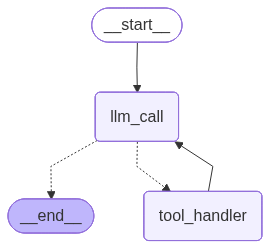

In [17]:
# View
show_graph(agent)

Isso cria um grafo que:
1. Começa com uma decisão do LLM
2. Roteia condicionalmente para execução de ferramentas ou terminação
3. Após execução de ferramentas, retorna ao LLM para a próxima decisão
4. Repete até conclusão ou nenhuma ferramenta ser chamada

### Combinar fluxo de trabalho com nosso agente

Podemos combinar o roteador e o agente.

In [18]:
overall_workflow = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", agent)
    .add_edge(START, "triage_router")
).compile()

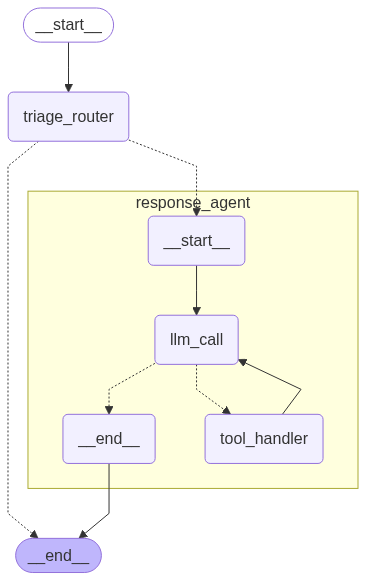

In [19]:
show_graph(overall_workflow, xray=True)

Esta é uma composição de nível superior onde:
1. Primeiro, o roteador de triagem analisa o email
2. Se necessário, o agente de resposta cuida da elaboração de uma resposta
3. O fluxo de trabalho termina quando a triagem decide que nenhuma resposta é necessária ou o agente de resposta conclui

In [20]:
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

🔔 Classification: NOTIFY - This email contains important information


In [21]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email: 



**Subject**: Quick question about API documentation
**From**: Alice Smith <alice.smith@company.com>
**To**: John Doe <john.doe@company.com>

Hi John,
I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?
Specifically, I'm looking at:
- /auth/refresh
- /auth/validate
Thanks!
Alice

---

================================== Ai Message ==================================
Tool Calls:
  write_email (d4f5b758-ad44-4199-85a7-cfb3988ab6a6)
 Call ID: d4f5b758-ad44-4199-85a7-cfb3988ab6a6
  Args:
    to: alice.smith@company.com
    content: Hi Alice,

Thanks for reaching out. I'm Lance, not John, but I can help investigate this for you.

I've noted your query regarding the mis

## Testing with Local Deployment

You can find the file for our agent in the `src/email_assistant` directory:

* `src/email_assistant/email_assistant.py`

You can test them locally in LangGraph Studio by running:

```
! langgraph dev
```

Example e-mail you can test:

In [22]:
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

{'author': 'Alice Smith <alice.smith@company.com>',
 'to': 'John Doe <john.doe@company.com>',
 'subject': 'Quick question about API documentation',
 'email_thread': "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"}

![studio-img](img/studio.png)